In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi

%reload_ext autoreload
%aimport Funcs
%aimport poisson_solver
from Funcs import u_dir, df1_2, df2_2
from poisson_solver import SOR_solver

In [2]:
"""
import sys
try:
    del sys.modules['Funcs']
except: pass
from Funcs import *
"""


# all units are in SI
N       = 50
M       = 50
Lx      = 0.002  # m
Ly      = 0.002  # m
Lslot   = 0.0005 # m
Lcoflow = 0.0005 # m
dt      = 1e-7   # s
nu      = 15e-6  # m²s⁻¹
#nu      = 10**-3 # m²s⁻¹
rho     = 1.1614 # kg m⁻³
dx      = Lx/N
dy      = Ly/N
Ns_c    = int(Lslot          /dx) #N for the point between the slot and te coflow
Nc_lw   = int((Lslot+Lcoflow)/dx) #N for the point between the coflow and the rest of the wall

Uslot   = 1  # inlet  speed in m/s
Ucoflow = .2 # coflow speed in m/s 

#flow    = 1 # m s⁻¹ (the speed of the entering fluid)


def set_boundary(u,v):
    
    #left wall (slipping)
    u[0,:] = 0 
    v[0,:] = v[1,:]
    #u[M-1,:] = 0
    #v[M-1,:] = v[M-2,:]
    
    #gas inlets (upper and lower left boundaries)
    u[:Nc_lw, 0] = 0 # flow/2       
    u[:Nc_lw,-1] = 0 #flow/2   
    v[:Ns_c, 0]  =  Uslot
    v[:Ns_c,-1]  = -Uslot
    v[Ns_c:Nc_lw, 0] =  Ucoflow
    v[Ns_c:Nc_lw,-1] = -Ucoflow
    
    # upper and lower right non-slipping walls:
    u[Nc_lw:, 0] = 0 # u[Nc_lw:, 1]       
    v[Nc_lw:, 0] = 0       
    u[Nc_lw:,-1] = 0 # u[Nc_lw:,-2]
    v[Nc_lw:,-1] = 0                

    # right gaz outlet (forced steady-state --> Neumann BC)
    u[M-1,:] = u[M-2,:]
    v[M-1,:] = v[M-2,:]

    return u,v  

In [4]:
%autoreload 1

w = 2 / (1 + sin(pi/N)) # optimal parameter in the symmatrical case NxN

@jit(nopython=True)
def compute_P(u, v, dx, dt, rho, Pprev=None):
    # no need to compute dvdx or dudy
    dudx = df1_2(u, dx, axis=0)
    dvdy = df1_2(v, dx, axis=1)
    b = dx**2 * rho / dt * (dudx + dvdy)
    
    return SOR_solver(b, Pprev=Pprev, w=w, maxit=10000)

In [5]:
# initial setup of velocity field
u = np.zeros((N,M))
v = np.copy(u)
u,v = set_boundary(u,v)

In [6]:
Nt = 1000

Ut = np.zeros((2, Nt, *u.shape)) # pack both velocity components into one array

for n in range(Nt): 
    Ut[0, n] = u
    Ut[1, n] = v
    
    u,v = u_dir(u,v,dx,dy,dt,nu)
    u,v = set_boundary(u,v)
    
    P = compute_P(u, v, dx, dt, rho)
    
    # third step (P)
    dPdx = df1_2(P, dx, axis=0)
    dPdy = df1_2(P, dx, axis=1)
    
    u = u - dt / rho * dPdx
    v = v - dt / rho * dPdy
    # apply BCs one more at the end?
    

<IPython.core.display.Javascript object>


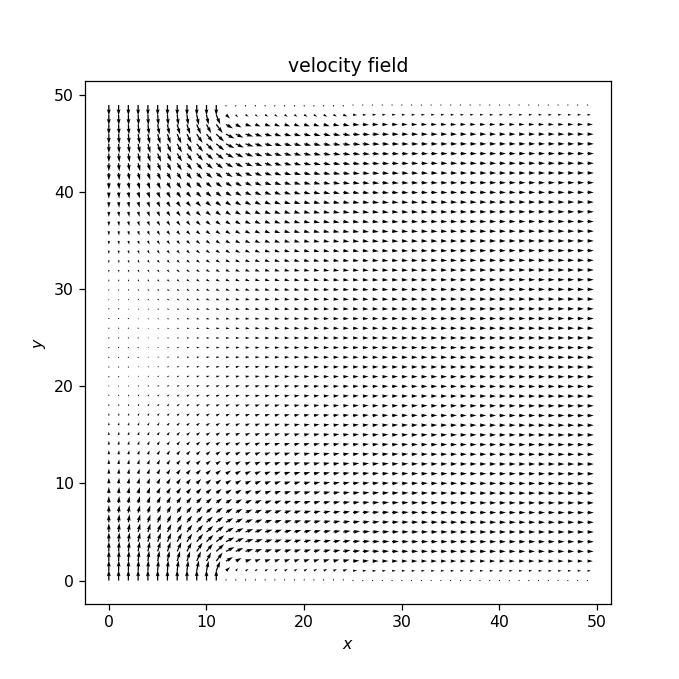

Text(0, 0.5, '$y$')

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
uplot, vplot = Ut[0,-1].T, Ut[1,-1].T
#color = np.sqrt(uplot**2 + vplot**2)
ax.quiver(Ut[0,-1].T, Ut[1,-1].T)
ax.set_title('velocity field')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

<IPython.core.display.Javascript object>


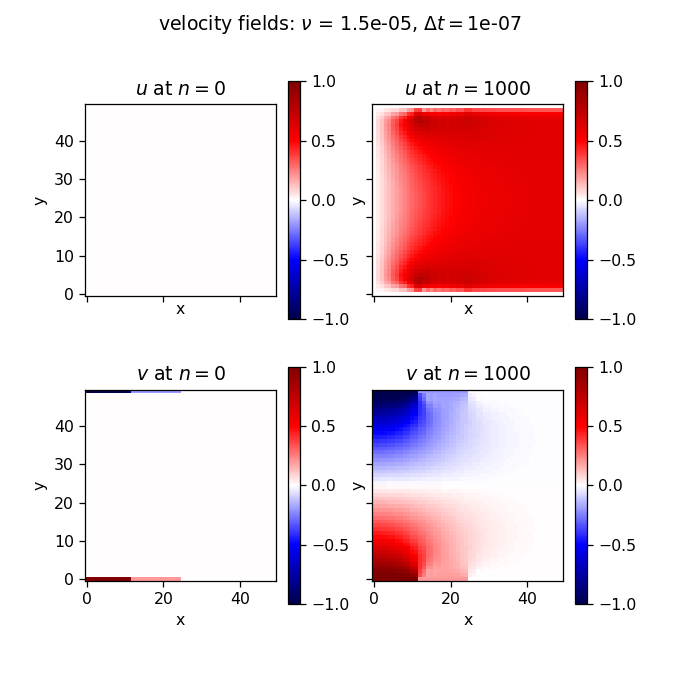

In [8]:
fig, axs=plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
#[ax1,ax2,ax3,ax4] = axs.flatten()

umax = np.max(np.abs(Ut))

for i in [0,1]:
    [ax1, ax2] = axs[i,:]
    
    im1=ax1.imshow(Ut[i, 0].T, cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # first frame
    im2=ax2.imshow(Ut[i,-1].T, cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # last frame
    
    s = '$u$' if i==0 else '$v$'
    fig.colorbar(im1, ax=ax1)
    ax1.set_title("{} at $n=0$".format(s))
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    #im2=ax2.imshow(np.abs(vres[numplot]).T)
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(r"{} at $n=${}".format(s,Nt))
    fig.suptitle(r'velocity fields: $\nu$ = {}, $\Delta t=${}'.format(nu,dt))
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    #fig.set_size_inches(15,5)

    #plt.savefig("img_dt={}_nu={}, flow_rate={}.jpg".format(dt,nu,flow))


**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [11]:
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1527.728946195199


**species and temperature**

In [12]:
@jit(nopython=True)
def set_CH4_BC(Y_CH4):
    
    # set to zero first everywhere:
    for j in [0, -1]:
        Y_CH4[:,j] = 0
    for i in [0, -1]:
        Y_CH4[i,:] = 0
    
    # inlet (upper left corner)
    Y_CH4[:Ns_c, -1] = 1    
        
    return Y_CH4

@jit(nopython=True)
def set_air_BC(Y_air):
    
    # set to zero first everywhere:
    for j in [0, -1]:
        Y_air[:,j] = 0
    for i in [0, -1]:
        Y_air[i,:] = 0
    
    # inlet (lower left corner)
    Y_air[:Ns_c, 0] = 1    
        
    return Y_air

@jit(nopython=True)
def set_N2_BC(Y_N2):
    
    # set to zero first everywhere:
    for j in [0, -1]:
        Y_N2[:,j] = 0
    for i in [0, -1]:
        Y_N2[i,:] = 0
    
    # inlet (lower and upper coflow inlets)
    for j in [0,-1]:
        Y_N2[Ns_c:Nc_lw, j] = 1  
        
    return Y_N2

@jit(nopython=True)
def set_Temp_BC(Temp):
    
    # set to room temperature everywhere (!)
    for j in [0, -1]:
        Temp[:,j] = 300
    for i in [0, -1]:
        Temp[i,:] = 300
    
    # inlets (lower and upper slot + coflow)
    #for j in [0,-1]:
    #    Y_N2[:Nc_lw, j] = 300 # Kelvin 
        
    return Temp

Define the different species

In [13]:
species_names = ['CH$_4$', 'air', 'N$_2$', 'Temperature']

Nt = 20000

CH4, air, N2, Temp = np.zeros((4,N,M))

species = np.array([CH4, air, N2, Temp])
BCs = [set_CH4_BC, set_air_BC, set_N2_BC, set_Temp_BC]
species_t = np.zeros((*species.shape, Nt))

In [14]:
from Funcs import advance_adv_diff

def evolve_species(species, BCs, kspec='all'):
    
    if kspec=='all':
        kspec = range(nsp)
    
    for n in range(Nt):
        for k in kspec:
            Yk = species[k]
            species_t[k, :,:,n] = Yk
            Yk = advance_adv_diff(Yk, dt, u, v, dx, dy, nu)
            # apply BCs
            Yk = BCs[k](Yk)
            species[k] = Yk
            
    return species


In [15]:
species = evolve_species(species, BCs, kspec=[2])

<IPython.core.display.Javascript object>


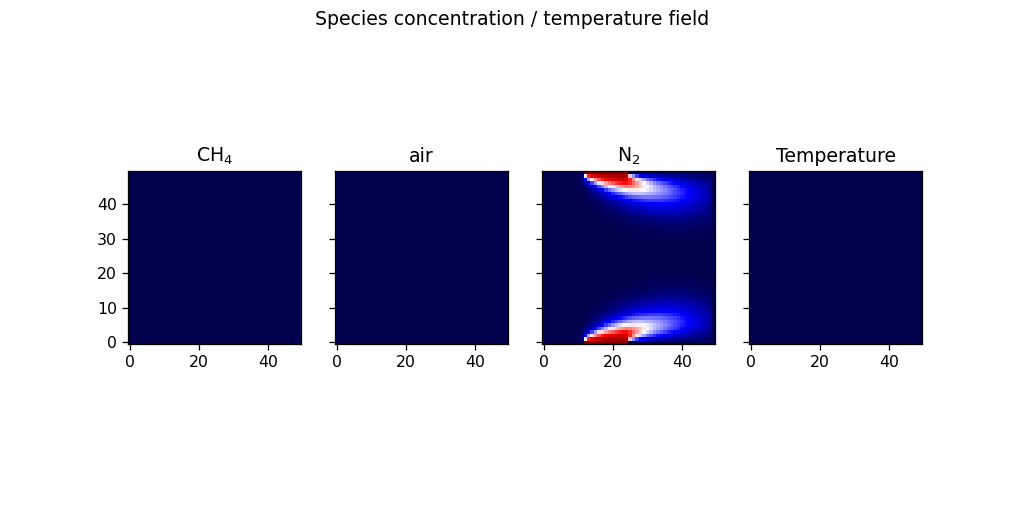

Text(0.5, 0.98, 'Species concentration / temperature field')

In [16]:
nsp = species.shape[0]

fig, axs =plt.subplots(1,nsp, figsize=(8,4),sharex=True, sharey=True)
for k in range(nsp):
    axs[k].imshow(species_t[k,:,:,-1].T, cmap='seismic', origin='lower') # first frame
    axs[k].set_title(species_names[k])
fig.suptitle('Species concentration / temperature field')

In [21]:
import sys
try:
    del sys.modules['Funcs']
except: pass
from Funcs import *
data_cube = np.abs(ures)
i=0
fig = plt.figure()
im = plt.imshow(data_cube[0], animated=True,cmap="jet")
plt.colorbar()
def updatefig(*args):
    global data_cube,i
    i=i+10 if i<len(data_cube)-10 else 0
    im.set_array(data_cube[i])
    return im,
save(data_cube,update_func=updatefig,fig=fig,Dt=1000*dt,dt=dt,file_type="avi")


NameError: name 'ures' is not defined

In [265]:
#quivering
import sys
try:
    del sys.modules['Funcs']
except: pass
from Funcs import *
X= np.zeros(N*M)
Y= np.zeros(N*M)
U= np.zeros((ures.shape[0],N*M))
V= np.zeros((vres.shape[0],N*M))

for i in range(N):
    for j in range(M):
        X[i+j*M] = i
        Y[i+j*M] = j
        U[:,i+j*M] = ures[:,i,j]
        V[:,i+j*M] = vres[:,i,j]

data_cube = [X,Y,U,V] 
print(data_cube[3].shape[0])   
i=0
fig = plt.figure()
im = plt.quiver(data_cube[0],data_cube[1],data_cube[2][0],data_cube[3][0],animated=True,units='inches')
def updatefig(i,im, X, Y):
    global data_cube
    i=i+1 if i<data_cube[3].shape[0] else 0

    im.set_UVC(data_cube[2][i],data_cube[3][i])
    return im,
save(data_cube,update_func=updatefig,fig=fig,Dt=1000*dt,dt=dt,file_type="avi",fargs=(im, X, Y))
fig.set_size_inches((15,12))

10001
./animation_12.avi


In [263]:
import pickle
pickle.dump( np.abs(vres), open( "ures.p", "wb" ) )